In [3]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [6]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
       
        self.fc0 = nn.Linear(128, 256)

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=5//2),
    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],1,16,16)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)        
        x = F.sigmoid(x)
        return x


In [7]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

X_dim = X_train.shape[1]
y_dim = y_train.shape[1]

X_train = X_train.reshape(ntrain,1,X_dim)
X_test = X_test.reshape(ntest,1,X_dim)

y_train = y_train.reshape(ntrain,1,16,16)
y_test = y_test.reshape(ntest,1,16,16)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('training data: measurements', X_train.shape, 'solution', y_train.shape)
print('training data: measurements', X_test.shape, 'solution', y_test.shape)

training data: measurements torch.Size([8000, 1, 128]) solution torch.Size([8000, 1, 16, 16])
training data: measurements torch.Size([2000, 1, 128]) solution torch.Size([2000, 1, 16, 16])


In [8]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [9]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

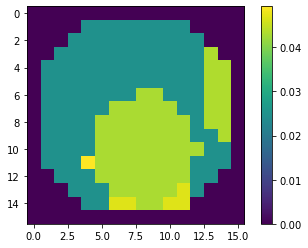

In [10]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

36481


c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 6.161125200000242 0.586032307818532 0.20630094611644745
1 2.46491789999709 0.18926326332986354 0.1762321967482567
2 2.536980600001698 0.1680333758443594 0.1700356948375702
3 2.340208399997209 0.1591853022426367 0.15261936497688294
4 2.315002399998775 0.15433222910761832 0.15284630542993546
5 2.803100099998119 0.15045010398328304 0.15266295754909515
6 2.5277100000021164 0.14750867687165736 0.1402774786055088
7 2.4022819999954663 0.1449919727668166 0.15374418312311172
8 2.53955020000285 0.143084201708436 0.14790325886011124
9 2.902872099999513 0.14207899536192417 0.13725243896245956
10 2.5047403999997186 0.14057670284807683 0.13671638053655624
11 2.354205199997523 0.13904910223186015 0.13809308406710624
12 2.373643800005084 0.1379221914038062 0.14322251641750336
13 2.3668035000009695 0.1361415142789483 0.13885445261001586
14 2.3283623999959673 0.13629665661603213 0.13777153807878495
15 2.356929100002162 0.13482688263803722 0.14125249028205872
16 2.3550958999985596 0.13389147067815066 0

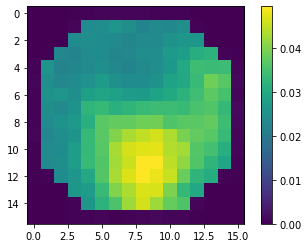

In [11]:
# SIGMA - TEST NETWORK
############################################################################

model_fcn_sigma = CNN_1().cuda()
print(count_params(model_fcn_sigma))
output_sigma = train_model(model_fcn_sigma, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_sigma = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [12]:
for param in output_sigma_model.parameters():
    

SyntaxError: incomplete input (4258999843.py, line 2)

In [ ]:
print(output_sigma_model.conv1.weight.detach().cpu().numpy())

plt.imshow(output_sigma_model.conv1.weight.detach().cpu().numpy()[100,0,:,:])
plt.colorbar()


In [ ]:
plt.imshow(output_sigma_model.conv1.weight.detach().cpu().numpy()[11,0,:,:])


In [ ]:
plt.imshow(output_sigma_model.conv2.weight.detach().cpu().numpy()[0,0,:,:])
plt.colorbar()


## No Activation at Output \
TOTAL TIME: ---60.02260470003239 \
RMSE: ---0.0037127026052949028---0.0013857613394051892 \
PSNR: ---22.69011644693345---2.028075345982437 \
SSIM: ---0.8060126236254511---0.04646556360044524 \
UQI: ---0.9899743358159191---0.0055662495667199675 \


# Sigmoid Activation at Output \
TOTAL TIME: ---51.887425200111466 \
RMSE: ---0.0034470120599841055---0.0015170417002827185 \
PSNR: ---23.428421555266524---2.6392534576879516 \
SSIM: ---0.8059130948960732---0.04777352207116035 \
UQI: ---0.9906065019419129---0.0066035246963146174 \



# Analaysis for Model

In [ ]:
# Models
#############################################################################
model = model_fcn_sigma
results =  results_sigma

In [ ]:
metric_type = 'ssim'         # can be the following rms, ssim, psnr

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_type))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_type)
plt.show

In [ ]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)



print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])


In [ ]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])


In [ ]:
print(outlier_list)

In [ ]:
#Actual
name = 'ccn_'
test_num = 1504

truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()


save_truth = name + metric_type + str(test_num)
#plt.savefig('./images/'+save_truth)

In [ ]:
# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

save_recon = save_truth + '_recon'
plt.savefig('./images/' + save_recon)

In [ ]:
test_num = 12

truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

print(truth_out.shape)

In [ ]:
temp = np.reshape(truth_out.numpy(),(16,16))
zoom = temp[2:5,12:15]

plt.imshow(zoom)
plt.colorbar()

In [ ]:
zoom_list = [(2,5,5,8),(2,5,12,15),(5,8,8,1),(6,9,2,5)]

In [ ]:
original = np.reshape(truth_out.numpy(),(16,16))

index = zoom_list[1]

original_box = original[index[0]:index[1],index[2]:index[3]]


plt.imshow(original_box)
plt.colorbar()

In [ ]:
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
recon = np.reshape(model(K).detach().cpu().numpy(),(16,16))

recon_box = recon[index[0]:index[1],index[2]:index[3]]

plt.imshow(recon_box)
plt.colorbar()